In [1]:
import pandas as pd
import numpy as np
import scipy as sp
from datetime import datetime
import pickle
import cloudpickle
import xgboost
import matplotlib.pyplot as plt
from IPython.display import display
import shap
from comparers import ModelComparer, plot_decision_boundary
from explainers import generate_shap_explanations, calc_feature_order, calc_class_order, calc_instance_order,\
                       plot_2d, plot_feature_importance_bar, plot_feature_importance_scatter,\
                       plot_feature_effects, plot_forces, merge_explanations, plot_decision,\
                       perform_hierarchical_clustering, plot_dendrogram, extract_clustering,\
                       get_class_occurences_in_clusters, plot_feature_influence_comparison,\
                       plot_class_importances, plot_feature_effects_comparison, ensure_shap_values_are_3d
from clustering import make_clustering
from tasks.cluster_example import make_task

In [2]:
with open('shap.expl', 'rb') as f:
    explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer = \
        pickle.load(f)

In [6]:
clf_a, clf_b, X, y, feature_names = make_task()

In [10]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

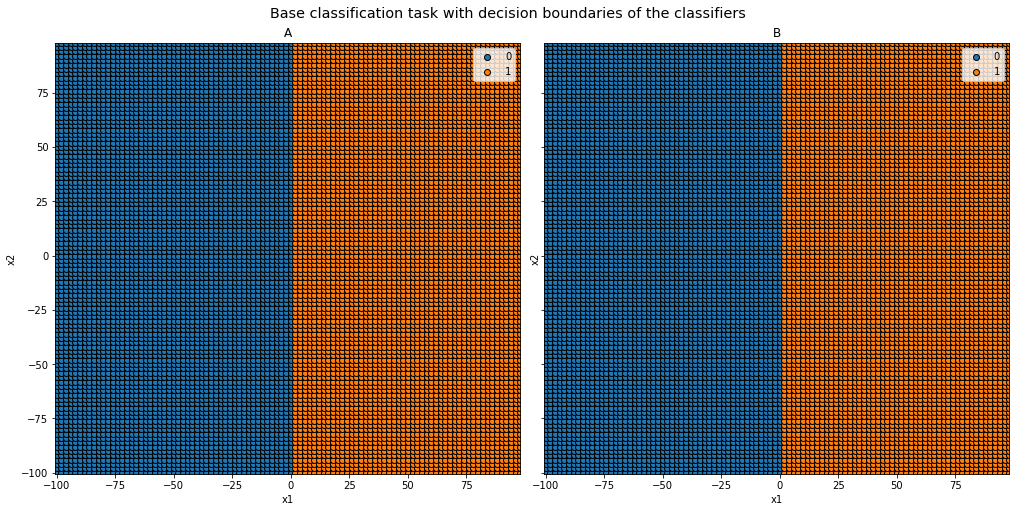

In [11]:
comparer.plot_individual_clf_decision_boundaries(X, y_true=y, kind='label')

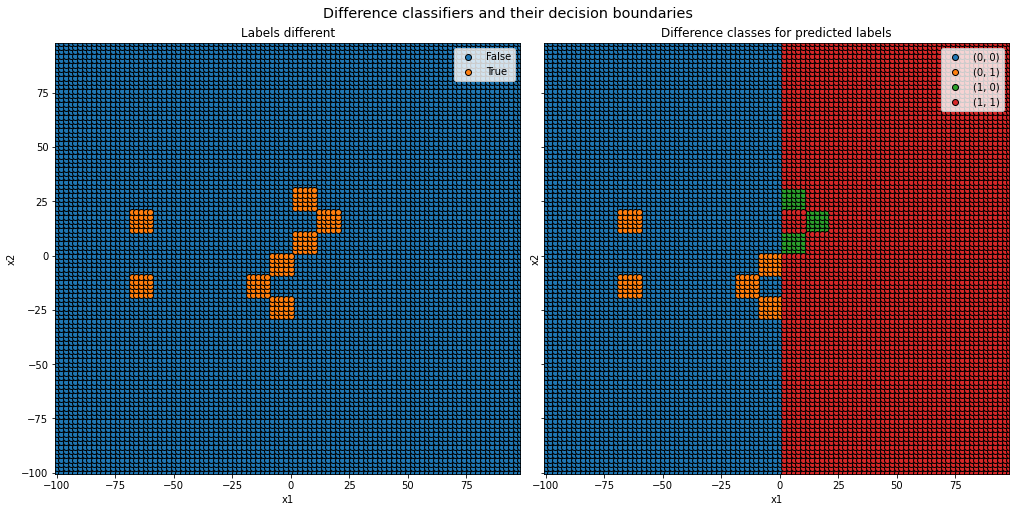

In [12]:
comparer.plot_decision_boundaries(X)

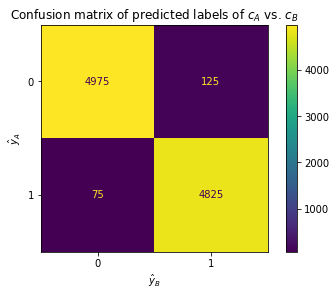

In [13]:
comparer.plot_confusion_matrix(X)

In [14]:
%%time
masker = shap.maskers.Independent(data=X, max_samples=X.shape[0])
explanations, indices_nonfinite_predictions, explanations_nonfinite = \
    generate_shap_explanations(comparer, X, masker=masker,
                               explanation_types=['indiv', 'indiv_diff', 'mclass_diff'],
                               space_types=['labels'])
with open('shap.expl', 'wb') as f:
    pickle.dump((explanations, indices_nonfinite_predictions, explanations_nonfinite, comparer),
                f, pickle.HIGHEST_PROTOCOL)

Exact explainer: 10001it [01:51, 83.21it/s]                           
Exact explainer: 10001it [03:24, 46.70it/s]                          
Exact explainer: 10001it [02:35, 59.42it/s]                           


CPU times: user 5min 39s, sys: 10.3 s, total: 5min 50s
Wall time: 7min 52s


In [15]:
explanations.shape, indices_nonfinite_predictions.shape, explanations_nonfinite.shape

((10000, 2), (0,), (0,))

# Global Explanations

In [3]:
X = pd.DataFrame(explanations.data, columns=explanations.feature_names)
is_pred_diff = comparer.predict_bin_diff(X)
mclass_diff = comparer.predict_mclass_diff(X)

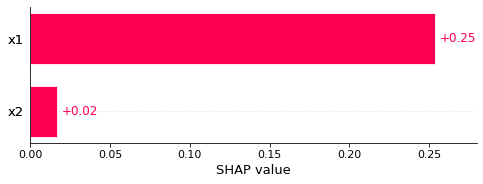

In [4]:
feature_order, feature_importances = calc_feature_order(explanations.mclass_diff.labels)
global_feature_order = feature_order
plot_feature_importance_bar(feature_importances)

In [5]:
global_data = pd.DataFrame(X, columns=explanations.feature_names)
global_data.iloc[:, global_feature_order].describe()

,x1,x2
count,10000.000000,10000.000000
mean,-1.000000,-1.000000
std,57.735027,57.735027
min,-100.000000,-100.000000
25%,-50.500000,-50.500000
50%,-1.000000,-1.000000
75%,48.500000,48.500000
max,98.000000,98.000000


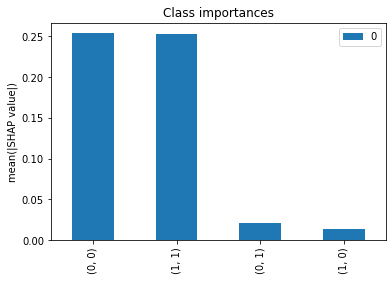

In [6]:
class_order, class_importances = calc_class_order(explanations.mclass_diff.labels)
plot_class_importances(class_importances, class_order, explanations.mclass_diff.output_names)

In [7]:
class_order = np.arange(class_order.shape[0])

In [8]:
def plot_next_feature():
    feature_idx = next(it)
    plot_feature_effects(explanations.mclass_diff.labels[:, [feature_idx], class_order], highlight=is_pred_diff, alpha=0.1)
it = iter(feature_order)

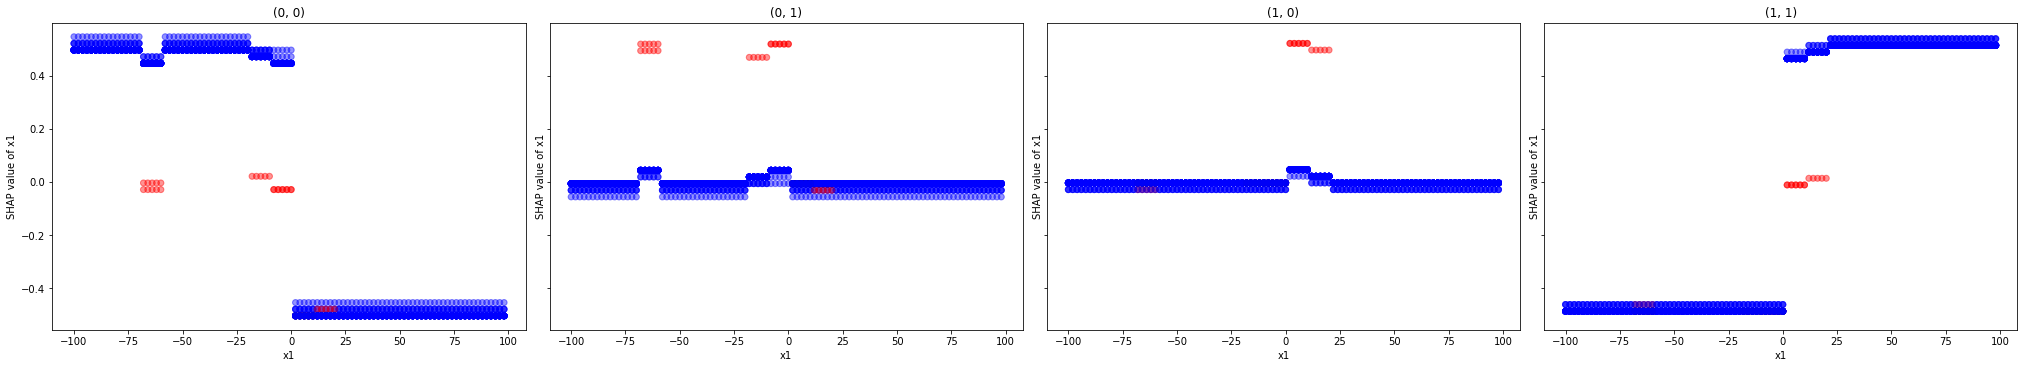

In [9]:
plot_next_feature()

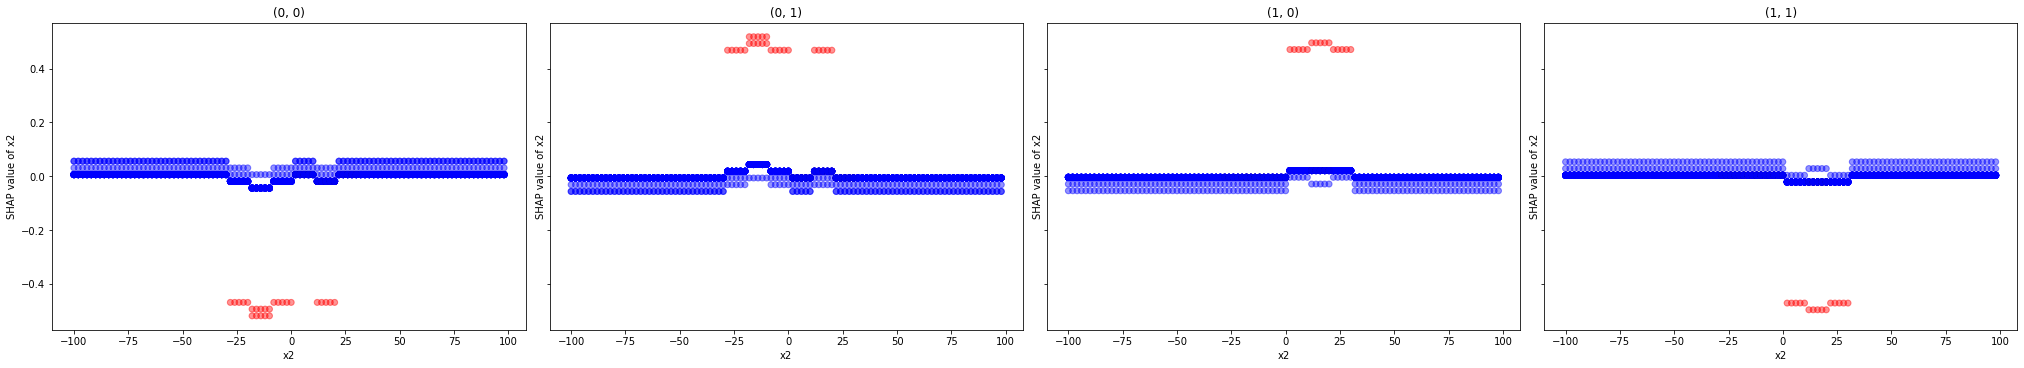

In [10]:
plot_next_feature()

# Local Explanations

## Local Explanations for Instances Classified $(0,1)$

### Clustering $(0,1)$ SHAP Values

In [9]:
clustering = make_clustering(comparer, explanations.mclass_diff.labels, '(0, 1)')

node #19998 (level 0)
(0, 0)    4975
(1, 1)    4825
(0, 1)     125
(1, 0)      75
dtype: int64


In [10]:
clustering.go_down()

node #19995 (level 1)
(0, 1)    125
dtype: int64


In [11]:
clustering.go_down()

node #14592 (level 2)
(0, 1)    75
dtype: int64


In [12]:
clustering.go_down()

node #6020 (level 3)
(0, 1)    1
dtype: int64


In [13]:
clustering.go_up()

node #14592 (level 2)
(0, 1)    75
dtype: int64


This approach clusters together instances in the areas of modification 2, 3 and 5 because their SHAP values of class $(0,1)$ are identical.

In [14]:
clustering.describe_feature('x1')

,global,local-all,local-diff
count,10000.000000,75.000000,75.000000
mean,-1.000000,-24.000000,-24.000000
std,57.735027,28.616759,28.616759
min,-100.000000,-68.000000,-68.000000
25%,-50.500000,-62.000000,-62.000000
50%,-1.000000,-6.000000,-6.000000
75%,48.500000,-2.000000,-2.000000
max,98.000000,0.000000,0.000000


In [15]:
clustering.describe_feature('x2')

,global,local-all,local-diff
count,10000.000000,75.000000,75.000000
mean,-1.000000,-4.000000,-4.000000
std,57.735027,16.684675,16.684675
min,-100.000000,-28.000000,-28.000000
25%,-50.500000,-22.000000,-22.000000
50%,-1.000000,-4.000000,-4.000000
75%,48.500000,14.000000,14.000000
max,98.000000,20.000000,20.000000


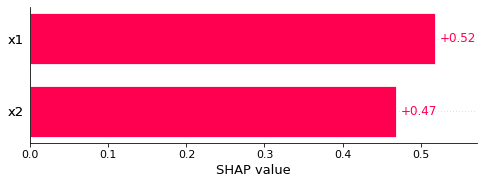

In [16]:
feature_order, feature_importances = calc_feature_order(clustering.shap_values[:, :, clustering.classes])
plot_feature_importance_bar(feature_importances)

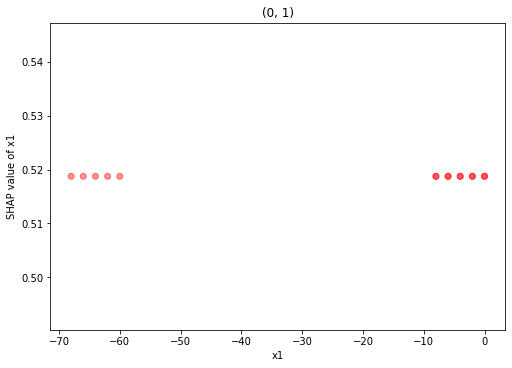

In [17]:
clustering.plot_feature('x1', alpha=0.1)

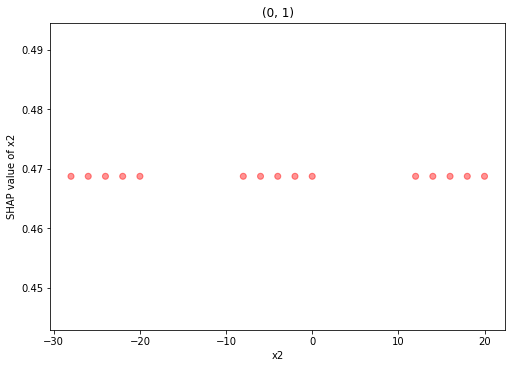

In [18]:
clustering.plot_feature('x2', alpha=0.1)

Since interpretations rely on SHAP values of adjacent classes as well, clustering needs to be done on SHAP values of multiple classes.

### Clustering of $(0,1)$ and Adjacent Classes' SHAP Values

In [19]:
clustering = make_clustering(comparer, explanations.mclass_diff.labels, '(0, 1)', '(0, 0)', '(1, 1)')

node #19998 (level 0)
(0, 0)    4975
(1, 1)    4825
(0, 1)     125
(1, 0)      75
dtype: int64


#### Cluster 1

In [20]:
clustering.go_down()

node #19996 (level 1)
(1, 1)    4825
(1, 0)      75
dtype: int64


In [21]:
clustering.get_next()

node #19998 (level 0)
(0, 0)    4975
(1, 1)    4825
(0, 1)     125
(1, 0)      75
dtype: int64
node #19997 (level 1)
(0, 0)    4975
(0, 1)     125
dtype: int64


In [22]:
clustering.go_down()

node #19990 (level 2)
(0, 1)    125
dtype: int64


In [23]:
clustering.go_down()

node #19977 (level 3)
(0, 1)    75
dtype: int64


In [24]:
clustering.go_down()

node #16558 (level 4)
(0, 1)    50
dtype: int64


In [25]:
clustering.go_down()

node #5050 (level 5)
(0, 1)    1
dtype: int64


Now the clustering is more fine grained: Only instances affected by modification 3 and 5 are assigned to this cluster, because they have equal $(0,1)$, $(0,0)$ and $(1,1)$ SHAP values. This allows for more precise explanations.

In [26]:
clustering.go_up()

node #16558 (level 4)
(0, 1)    50
dtype: int64


Cluster characteristics:
- $-8 ≤ x1 ≤ 0$
- $-28 ≤ x2 ≤ 0$

In [27]:
clustering.describe_feature('x1')

,global,local-all,local-diff
count,10000.000000,50.000000,50.000000
mean,-1.000000,-4.000000,-4.000000
std,57.735027,2.857143,2.857143
min,-100.000000,-8.000000,-8.000000
25%,-50.500000,-6.000000,-6.000000
50%,-1.000000,-4.000000,-4.000000
75%,48.500000,-2.000000,-2.000000
max,98.000000,0.000000,0.000000


In [28]:
clustering.describe_feature('x2')

,global,local-all,local-diff
count,10000.000000,50.000000,50.000000
mean,-1.000000,-14.000000,-14.000000
std,57.735027,10.497813,10.497813
min,-100.000000,-28.000000,-28.000000
25%,-50.500000,-24.000000,-24.000000
50%,-1.000000,-14.000000,-14.000000
75%,48.500000,-4.000000,-4.000000
max,98.000000,0.000000,0.000000


Counterfactuals:
- $x1=-10 \lor 1$
- $x2=-30 \lor 1$

In [36]:
clustering.test(x1=-10)

,before,after
"(0, 0)",NaN,50.0
"(0, 1)",50.0,NaN


In [38]:
clustering.test(x1=1)

,before,after
"(0, 1)",50.0,NaN
"(1, 1)",NaN,50.0


In [41]:
clustering.test(x2=-30)

,before,after
"(0, 0)",NaN,50.0
"(0, 1)",50.0,NaN


In [42]:
clustering.test(x2=1)

,before,after
"(0, 0)",NaN,50.0
"(0, 1)",50.0,NaN


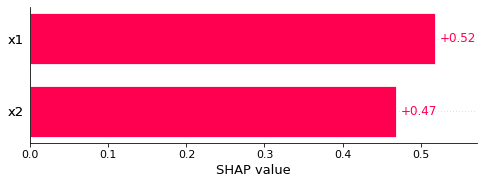

In [29]:
feature_order, feature_importances = calc_feature_order(clustering.shap_values[:, :, clustering.classes])
plot_feature_importance_bar(feature_importances)

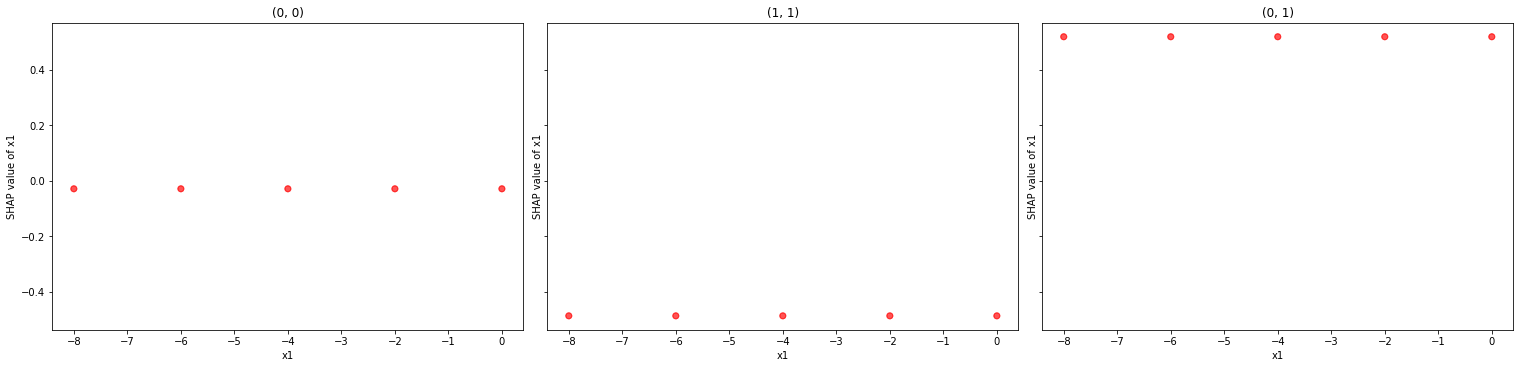

In [32]:
clustering.plot_feature('x1', classes=clustering.cluster_classes, alpha=0.1)

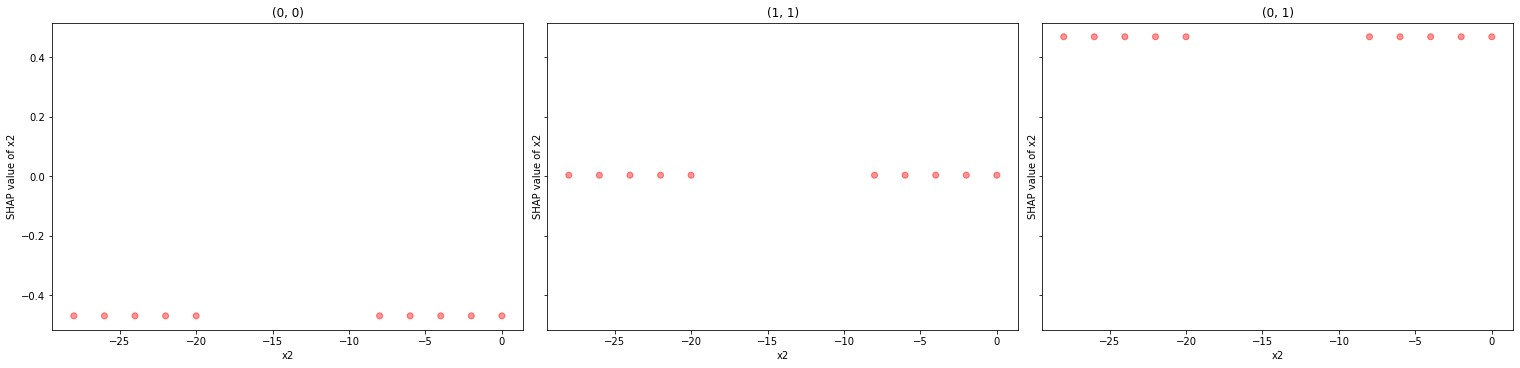

In [33]:
clustering.plot_feature('x2', classes=clustering.cluster_classes, alpha=0.1)

Adding the other difference class $(1,0)$ to the input of the clustering wouldn't create separate clusters for the two modifications, because this classes SHAP values are also equal. The only option would be to switch to a different kind of clustering, that also takes into account the original data. The authors of the SHAP algorithm have proposed such a method as well (TODO cite), a kind of supervised clustering. It trains a regression tree to predict the SHAP values from the original data, and uses to nodes to cluster the instances. In this limited work, I did not assess whether this approach yields a better clustering, yet it is a promising option.

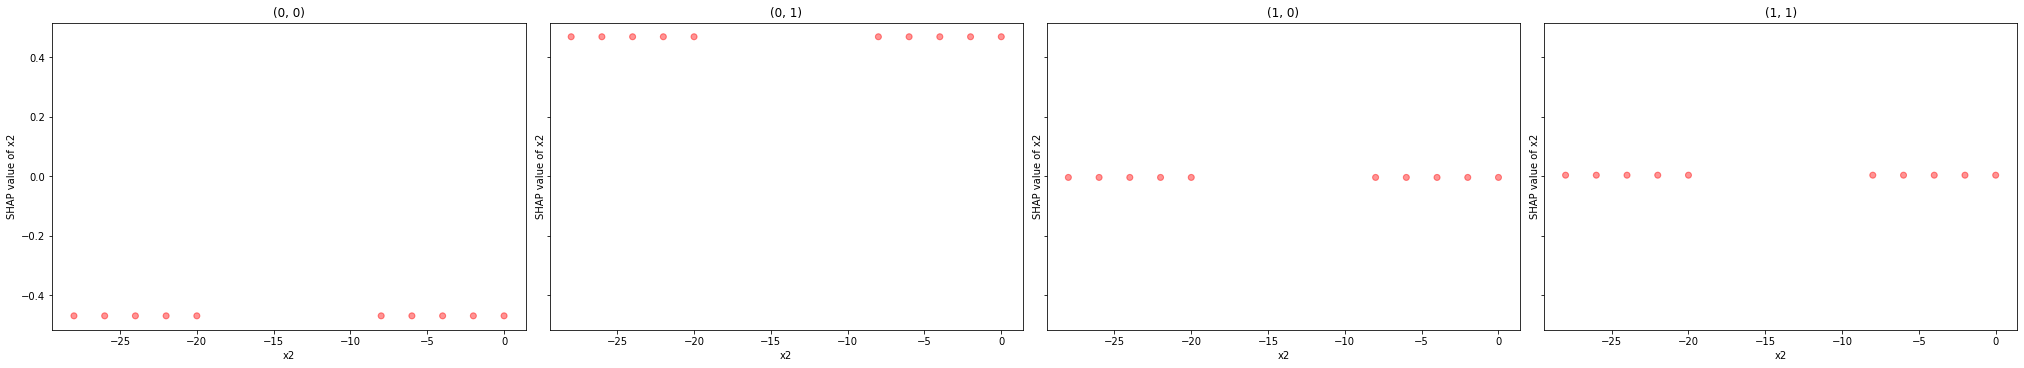

In [34]:
clustering.plot_feature('x2', classes=clustering.shap_values.output_names, alpha=0.1)

#### Cluster 2

This cluster contains instances affected by modification 1.

In [43]:
clustering.get_next()

node #19977 (level 3)
(0, 1)    75
dtype: int64
node #16582 (level 4)
(0, 1)    25
dtype: int64


Cluster characteristics:
- $-68 ≤ x1 ≤ -60$
- $12 ≤ x2 ≤ 20$

In [44]:
clustering.describe_feature('x1')

,global,local-all,local-diff
count,10000.000000,25.000000,25.000000
mean,-1.000000,-64.000000,-64.000000
std,57.735027,2.886751,2.886751
min,-100.000000,-68.000000,-68.000000
25%,-50.500000,-66.000000,-66.000000
50%,-1.000000,-64.000000,-64.000000
75%,48.500000,-62.000000,-62.000000
max,98.000000,-60.000000,-60.000000


In [45]:
clustering.describe_feature('x2')

,global,local-all,local-diff
count,10000.000000,25.000000,25.000000
mean,-1.000000,16.000000,16.000000
std,57.735027,2.886751,2.886751
min,-100.000000,12.000000,12.000000
25%,-50.500000,14.000000,14.000000
50%,-1.000000,16.000000,16.000000
75%,48.500000,18.000000,18.000000
max,98.000000,20.000000,20.000000


Counterfactuals:
- $x1=-70 \lor -59$
- $x2=10 \lor 21$

In [47]:
clustering.test(x1=-70)

,before,after
"(0, 0)",NaN,25.0
"(0, 1)",25.0,NaN


In [49]:
clustering.test(x1=-59)

,before,after
"(0, 0)",NaN,25.0
"(0, 1)",25.0,NaN


In [52]:
clustering.test(x2=10)

,before,after
"(0, 0)",NaN,25.0
"(0, 1)",25.0,NaN


In [54]:
clustering.test(x2=21)

,before,after
"(0, 0)",NaN,25.0
"(0, 1)",25.0,NaN


#### Cluster 3

In [55]:
clustering.get_next()

node #19977 (level 3)
(0, 1)    75
dtype: int64
node #19990 (level 2)
(0, 1)    125
dtype: int64
node #19984 (level 3)
(0, 1)    50
dtype: int64


In [56]:
clustering.go_down()

node #14519 (level 4)
(0, 1)    25
dtype: int64


Cluster characteristics:
- $-68 ≤ x1 ≤ -60$
- $-18 ≤ x2 ≤ -10$

In [57]:
clustering.describe_feature('x1')

,global,local-all,local-diff
count,10000.000000,25.000000,25.000000
mean,-1.000000,-64.000000,-64.000000
std,57.735027,2.886751,2.886751
min,-100.000000,-68.000000,-68.000000
25%,-50.500000,-66.000000,-66.000000
50%,-1.000000,-64.000000,-64.000000
75%,48.500000,-62.000000,-62.000000
max,98.000000,-60.000000,-60.000000


In [58]:
clustering.describe_feature('x2')

,global,local-all,local-diff
count,10000.000000,25.000000,25.000000
mean,-1.000000,-14.000000,-14.000000
std,57.735027,2.886751,2.886751
min,-100.000000,-18.000000,-18.000000
25%,-50.500000,-16.000000,-16.000000
50%,-1.000000,-14.000000,-14.000000
75%,48.500000,-12.000000,-12.000000
max,98.000000,-10.000000,-10.000000


Counterfactuals:
- $x1=-70 \lor -59$
- $x2=-20 \lor -9$

In [60]:
clustering.test(x1=-70)

,before,after
"(0, 0)",NaN,25.0
"(0, 1)",25.0,NaN


In [62]:
clustering.test(x1=-59)

,before,after
"(0, 0)",NaN,25.0
"(0, 1)",25.0,NaN


In [65]:
clustering.test(x2=-20)

,before,after
"(0, 0)",NaN,25.0
"(0, 1)",25.0,NaN


In [67]:
clustering.test(x2=-9)

,before,after
"(0, 0)",NaN,25.0
"(0, 1)",25.0,NaN


#### Cluster 4

This cluster contains instances affected by modification 4.

In [68]:
clustering.get_next()

node #19984 (level 3)
(0, 1)    50
dtype: int64
node #14523 (level 4)
(0, 1)    25
dtype: int64


Characteristics:
- $-18 ≤ x1 ≤ -10$
- $-18 ≤ x2 ≤ -10$

In [69]:
clustering.describe_feature('x1')

,global,local-all,local-diff
count,10000.000000,25.000000,25.000000
mean,-1.000000,-14.000000,-14.000000
std,57.735027,2.886751,2.886751
min,-100.000000,-18.000000,-18.000000
25%,-50.500000,-16.000000,-16.000000
50%,-1.000000,-14.000000,-14.000000
75%,48.500000,-12.000000,-12.000000
max,98.000000,-10.000000,-10.000000


In [70]:
clustering.describe_feature('x2')

,global,local-all,local-diff
count,10000.000000,25.000000,25.000000
mean,-1.000000,-14.000000,-14.000000
std,57.735027,2.886751,2.886751
min,-100.000000,-18.000000,-18.000000
25%,-50.500000,-16.000000,-16.000000
50%,-1.000000,-14.000000,-14.000000
75%,48.500000,-12.000000,-12.000000
max,98.000000,-10.000000,-10.000000


Counterfactuals:
- $x1=-20 \lor -9$
- $x2=-20 \lor -9$

In [71]:
clustering.test(x1=-20)

,before,after
"(0, 0)",NaN,25.0
"(0, 1)",25.0,NaN


In [72]:
clustering.test(x1=-9)

,before,after
"(0, 0)",NaN,25.0
"(0, 1)",25.0,NaN


In [73]:
clustering.test(x2=-20)

,before,after
"(0, 0)",NaN,25.0
"(0, 1)",25.0,NaN


In [74]:
clustering.test(x2=-9)

,before,after
"(0, 0)",NaN,25.0
"(0, 1)",25.0,NaN


### Clustering of $(1,0)$ and Adjacent Classes' SHAP Values

In [87]:
clustering = make_clustering(comparer, explanations.mclass_diff.labels, '(1, 0)', '(0, 0)', '(1, 1)')

node #19998 (level 0)
(0, 0)    4975
(1, 1)    4825
(0, 1)     125
(1, 0)      75
dtype: int64


#### Cluster 1

In [88]:
clustering.go_down()

node #19996 (level 1)
(0, 0)    4975
(0, 1)     125
dtype: int64


In [89]:
clustering.get_next()

node #19998 (level 0)
(0, 0)    4975
(1, 1)    4825
(0, 1)     125
(1, 0)      75
dtype: int64
node #19997 (level 1)
(1, 1)    4825
(1, 0)      75
dtype: int64


In [90]:
clustering.go_down()

node #19985 (level 2)
(1, 0)    75
dtype: int64


This cluster contains instances affected by modification 7.

In [91]:
clustering.go_down()

node #19942 (level 3)
(1, 0)    25
dtype: int64


Cluster characteristics:
- $12 ≤ x1 ≤ 20$
- $12 ≤ x2 ≤ 20$

In [92]:
clustering.describe_feature('x1')

,global,local-all,local-diff
count,10000.000000,25.000000,25.000000
mean,-1.000000,16.000000,16.000000
std,57.735027,2.886751,2.886751
min,-100.000000,12.000000,12.000000
25%,-50.500000,14.000000,14.000000
50%,-1.000000,16.000000,16.000000
75%,48.500000,18.000000,18.000000
max,98.000000,20.000000,20.000000


In [93]:
clustering.describe_feature('x2')

,global,local-all,local-diff
count,10000.000000,25.000000,25.000000
mean,-1.000000,16.000000,16.000000
std,57.735027,2.886751,2.886751
min,-100.000000,12.000000,12.000000
25%,-50.500000,14.000000,14.000000
50%,-1.000000,16.000000,16.000000
75%,48.500000,18.000000,18.000000
max,98.000000,20.000000,20.000000


Counterfactuals:
- $x1=10 \lor 21$
- $x2=10 \lor 21$

In [94]:
clustering.test(x1=10)

,before,after
"(1, 0)",25.0,NaN
"(1, 1)",NaN,25.0


In [95]:
clustering.test(x1=21)

,before,after
"(1, 0)",25.0,NaN
"(1, 1)",NaN,25.0


In [96]:
clustering.test(x2=10)

,before,after
"(1, 0)",25.0,NaN
"(1, 1)",NaN,25.0


In [97]:
clustering.test(x2=21)

,before,after
"(1, 0)",25.0,NaN
"(1, 1)",NaN,25.0


#### Cluster 2

In [98]:
clustering.get_next()

node #19985 (level 2)
(1, 0)    75
dtype: int64
node #19966 (level 3)
(1, 0)    50
dtype: int64


In [99]:
clustering.go_down()

node #6555 (level 4)
(1, 0)    1
dtype: int64


This cluster contains instances affected by modifications 6 and 8. They are put together into one cluster because all instances have equal SHAP values.

In [100]:
clustering.go_up()

node #19966 (level 3)
(1, 0)    50
dtype: int64


Cluster characteristics:
- $2 ≤ x1 ≤ 10$
- $2 ≤ x2 ≤ 30$

In [101]:
clustering.describe_feature('x1')

,global,local-all,local-diff
count,10000.000000,50.000000,50.000000
mean,-1.000000,6.000000,6.000000
std,57.735027,2.857143,2.857143
min,-100.000000,2.000000,2.000000
25%,-50.500000,4.000000,4.000000
50%,-1.000000,6.000000,6.000000
75%,48.500000,8.000000,8.000000
max,98.000000,10.000000,10.000000


In [102]:
clustering.describe_feature('x2')

,global,local-all,local-diff
count,10000.000000,50.000000,50.000000
mean,-1.000000,16.000000,16.000000
std,57.735027,10.497813,10.497813
min,-100.000000,2.000000,2.000000
25%,-50.500000,6.000000,6.000000
50%,-1.000000,16.000000,16.000000
75%,48.500000,26.000000,26.000000
max,98.000000,30.000000,30.000000


Counterfactuals:
- $x1=0 \lor 11$
- $x2=0 \lor 31$

In [105]:
clustering.test(x1=0)

,before,after
"(0, 0)",NaN,50.0
"(1, 0)",50.0,NaN


In [106]:
clustering.test(x1=11)

,before,after
"(1, 0)",50.0,NaN
"(1, 1)",NaN,50.0


In [108]:
clustering.test(x2=0)

,before,after
"(1, 0)",50.0,NaN
"(1, 1)",NaN,50.0


In [109]:
clustering.test(x2=31)

,before,after
"(1, 0)",50.0,NaN
"(1, 1)",NaN,50.0
